Imports

In [1]:
import numpy as np
import os

os.environ["OPENCV_LOG_LEVEL"] = "SILENT"
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

import tensorflow as tf
import cv2

physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

from keras import layers
from Segmentation_classification.utils.pconv_layer import PConv2D
# from keras.src import backend
# backend.update
from keras.applications.efficientnet_v2 import EfficientNetV2B0
from livelossplot import PlotLossesKeras
import pandas as pd
import numpy as np

from dvclive import Live
from dvclive.keras import DVCLiveCallback


2024-02-08 12:03:54.109906: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-08 12:03:54.109952: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-08 12:03:54.129415: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Preprocessing

In [2]:
cv2.setNumThreads(cv2.getNumThreads())

def extract(mode='train', dim=256):

    def gen_mask(polygon_coords):
        width, height = dim, dim
        # image = np.zeros((height, width), dtype=np.uint8)

        # Create a polygon mask
        polygon_mask = np.zeros((height, width), dtype=np.int32)
        for val, coord in enumerate(polygon_coords, 1):
            cv2.fillPoly(polygon_mask, [coord], 1)
        return polygon_mask

    def preproc_polycoord(coord):  # convert and reshape float coordinates into int
        poly_coord_ = np.array(coord).reshape((-1, 2))  # reshape to (x, y)
        # convert coordinates range in (0-1) to image shape ie 256
        poly_coord_ *= dim
        poly_coord_ = np.round(poly_coord_).astype('int32')
        return poly_coord_

    X, Y1, Y2 = [], [], []
    count = 0
    for file in os.scandir(f'dataset/full_teeth/{mode}/labels'):
        with open(file.path, 'r') as dt:
            text = dt.read()

        if len(np_txt := text.split('\n')) == 2:
            cls_txt = [int(np.fromstring(i, sep=' ')[0]) for i in np_txt]
            np_txt = [np.fromstring(i, sep=' ')[1:] for i in np_txt]
        else:
            continue

        poly_coord = [preproc_polycoord(i) for i in np_txt]
        mask_img = gen_mask(poly_coord)
        # plt.imshow(mask_img , cmap='gray')
        # plt.show()

        img = cv2.imread(file.path.replace(
            'labels', 'images').split('.')[0]+'.jpeg')

        if img is not None:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (dim, dim))
            X.append(img)
            Y1.append(mask_img)
            Y2.append(cls_txt)
            count += 1
        elif count > 100000:
            break
        else:
            continue
    
    Y2 = np.array(Y2)
    return np.array(X).astype(np.int32), np.array(Y1), Y2[:, 0], Y2[:, 1]

dim=640
X_train, Y_train1, Y_train2, Y_train3 = extract(dim=dim)
# X_test, Y_test1, Y_test2, Y_test3 = extract(mode='test', dim=dim)
X_val, Y_val1, Y_val2, Y_val3 = extract(mode='validate', dim=dim)


Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


Partial Conv

In [3]:

class SegmentImg(layers.Layer):
    def __init__(self):
        super().__init__()

    def call(self, inputs):
        y_, segment_region = inputs

        y_ = tf.cast(y_, dtype=tf.int32)
        segment_region = tf.cast(segment_region, dtype=tf.int32)

        mask = tf.logical_or(tf.equal(y_, 0),
                        tf.equal(y_, segment_region))
        mask = tf.cast(mask, dtype=tf.float32)
        mask = tf.expand_dims(mask, axis=-1)
        return tf.tile(mask, [1, 1, 1, 3])


x = layers.Input(shape=(dim, dim, 3))
y = layers.Input(shape=(dim, dim))
mask1 = SegmentImg()([y, 2])
mask2 = SegmentImg()([y, 1])
x = layers.Normalization()(x)

x1, mask1 = PConv2D(64, 7, strides=2, padding='same', activation='relu')([x, mask1])
x1, mask1 = PConv2D(128, 5, strides=2, padding='same', activation='relu')([x1, mask1])
x1 = layers.BatchNormalization()(x1)
x1 = layers.Activation('relu')(x1)
for _ in range(20):
    x1, mask1 = PConv2D(256, 3, strides=2, padding='same', activation='relu')([x1, mask1])
    x1 = layers.BatchNormalization()(x1)
    # x1 = layers.Activation('relu')(x1)

x1 = layers.GlobalAveragePooling2D()(x1)
x1 = layers.Dense(256, activation='relu')(x1)
output1 = layers.Dense(4, activation='softmax', name='clss1')(x1)

x2, mask2 = PConv2D(64, 7, strides=2, padding='same', activation='relu')([x, mask2])
# x2 = layers.Activation('relu')(x2)
x2, mask2 = PConv2D(128, 3, strides=2, padding='same', activation='relu')([x2, mask2])
x2 = layers.BatchNormalization()(x2)
x2 = layers.Activation('relu')(x2)
for _ in range(20):
    x2, mask2 = PConv2D(32, 3, strides=2, padding='same', activation='relu')([x2, mask2])
    x2 = layers.BatchNormalization()(x2)
    # x2 = layers.Activation('relu')(x2)

x2 = layers.GlobalAveragePooling2D()(x2)
x2 = layers.Dense(256, activation='relu')(x2)
output2 = layers.Dense(4, activation='softmax', name='clss2')(x2)

model = tf.keras.Model(inputs=[x, y], outputs = [output1, output2])
# model.summary()
# tf.keras.utils.plot_model(
#     model,
#     to_file="PConv.png",
#     show_shapes=True,
#     show_dtype=True,
#     show_layer_names=True,
#     rankdir="TB",
#     expand_nested=False,
#     dpi=128,
#     layer_range=None,
#     show_layer_activations=True,
#     show_trainable=True,
# )
model.output_names = ['clss1', 'clss2']




Training

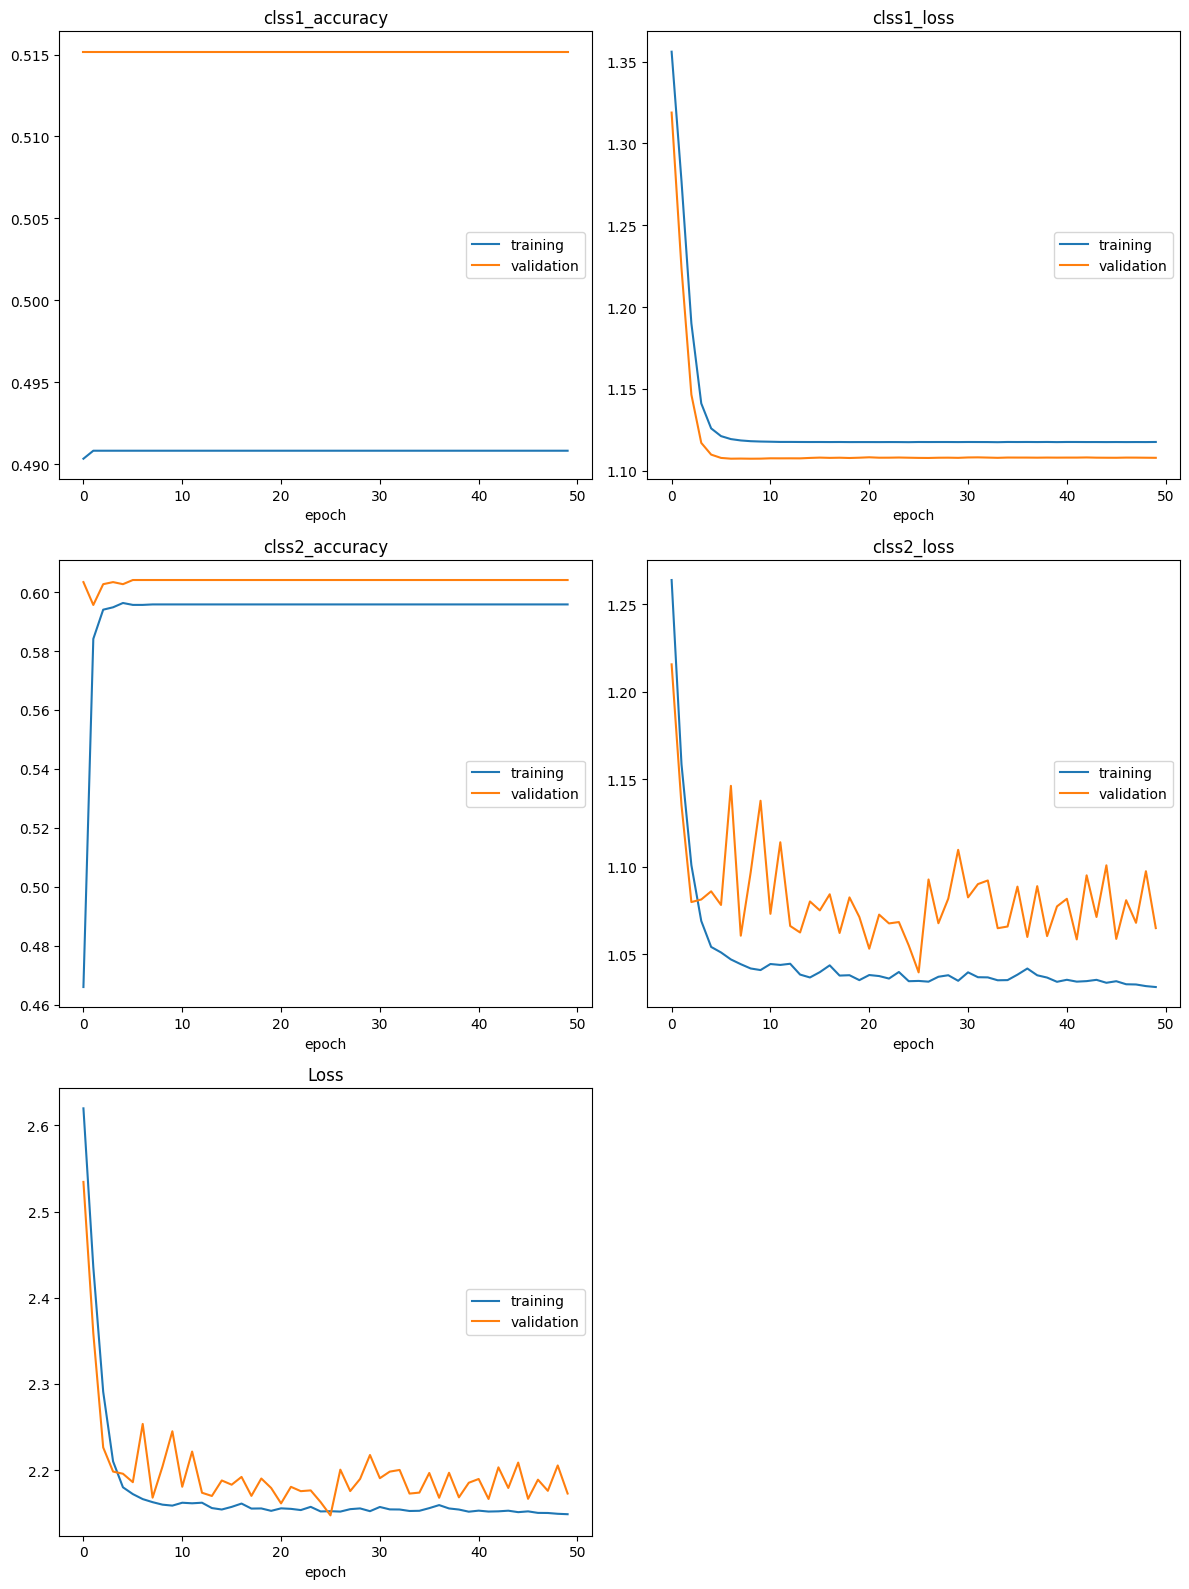

clss1_accuracy
	training         	 (min:    0.490, max:    0.491, cur:    0.491)
	validation       	 (min:    0.515, max:    0.515, cur:    0.515)
clss1_loss
	training         	 (min:    1.117, max:    1.356, cur:    1.118)
	validation       	 (min:    1.107, max:    1.319, cur:    1.108)
clss2_accuracy
	training         	 (min:    0.466, max:    0.596, cur:    0.596)
	validation       	 (min:    0.596, max:    0.604, cur:    0.604)
clss2_loss
	training         	 (min:    1.031, max:    1.264, cur:    1.031)
	validation       	 (min:    1.040, max:    1.216, cur:    1.065)
Loss
	training         	 (min:    2.149, max:    2.620, cur:    2.149)
	validation       	 (min:    2.147, max:    2.534, cur:    2.173)
771/771 [==============================] - 95s 123ms/step - loss: 2.1488 - clss1_loss: 1.1176 - clss2_loss: 1.0313 - clss1_accuracy: 0.4908 - clss2_accuracy: 0.5958 - val_loss: 2.1728 - val_clss1_loss: 1.1079 - val_clss2_loss: 1.0649 - val_clss1_accuracy: 0.5152 - val_clss2_accuracy

In [4]:
model_name = str(dim)+'Pconv_model'
model.compile(optimizer=tf.optimizers.RMSprop(learning_rate=0.00001),
              loss={'clss1': 'sparse_categorical_crossentropy',
                    'clss2': 'sparse_categorical_crossentropy'},
              metrics={'clss1': 'accuracy', 'clss2': 'accuracy'})
with Live() as live:
      model.fit([X_train, Y_train1], {'clss1': Y_train2, 'clss2': Y_train3}, batch_size=8, epochs=50, verbose=1,
          validation_data=([X_val, Y_val1], [Y_val2, Y_val3]), validation_batch_size=8,
          callbacks=[PlotLossesKeras(), DVCLiveCallback(live=live)])
      
      model.save(model_name + '.keras')
      live.log_artifact(model_name + '.keras', type=model_name)
# loss, accuracy = model.evaluate(X_test, [Y_test1, Y_test2, Y_test3])
# error = 197871

In [ ]:
# model.summary()
hist_df = pd.DataFrame(model.history.history)
hist_df.to_csv(model_name +'.csv', index=False)
# model.save("seg_clss_iter1.keras")

In [ ]:
# model = tf.keras.models.load_model('segmentation.tf')
img = cv2.imread(
    "fullteeth/test/images/0015w00002NZScQAAX_4dff1fe0-4fc1-11eb-9072-8fb3c6ce79ed-checkinsmileon-1687979590788.jpeg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_res = cv2.resize(img, (256, 256)).reshape((1, 256, 256, 3))
# pred = model.predict(img_res)

In [ ]:
img.dtype

In [ ]:
import matplotlib.pyplot as plt

pred_img = np.argmax(pred, 3).reshape((256, 256))
plt.imshow(img_res.reshape((256, 256, 3)))
plt.show()
plt.imshow(pred_img.astype(np.uint))
plt.show()

In [ ]:
import matplotlib.pyplot as plt
resized_img = np.copy(img_res)
contours, _ = cv2.findContours(pred_img.astype(
    np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
largest_contour = max(contours, key=cv2.contourArea)

# Convert the contour to a list of polygon coordinates
polygon_coords = largest_contour.reshape(-1, 2)
# Optionally, you can round the coordinates to integer values
polygon_coords = np.round(polygon_coords).astype(int)
# Print or use the polygon coordinates
print("Polygon Coordinates:")
cv2.drawContours(resized_img, [polygon_coords], -1,
                 (255, 255, 255), thickness=cv2.FILLED)
plt.imshow(resized_img)
plt.show()

In [ ]:
loss, accuracy = model.evaluate(X_test, Y_test)